# TF-IDF 성능 확인

TF-IDF를 이용하면 top-k에 따른 recall이 어느 정도 나오는지 확인
먼저 TF-IDF을 구한다.

In [1]:
import sys, os
dir_path = os.path.dirname(os.path.abspath(''))
src_path = os.path.join(dir_path, 'src')
sys.path.append(src_path)

In [2]:
from Retrieval.sparse_retrieval import SparseRetrieval
from config import Config
from transformers import AutoTokenizer

In [3]:
config = Config(path='../config.yaml')
tokenizer = AutoTokenizer.from_pretrained(config.model.name())

e:\miniconda\envs\w08-hw01\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
retriever = SparseRetrieval(tokenize_fn=tokenizer.tokenize, context_path='../data/wikipedia_documents.json')

Lengths of unique contexts : 56737


In [5]:
retriever.get_sparse_embedding()

Embedding pickle load.


이제 데이터셋을 불러온 후,  
top-k에 따른 recall을 구해보자.  

In [6]:
from datasets import load_from_disk
import json

In [7]:
dataset = load_from_disk('../data/train_dataset')
with open('../data/wikipedia_documents.json', 'r') as f:
    wikipedia = json.load(f)

In [8]:
train_dataset = dataset["train"]
questions = train_dataset['question']
answers = train_dataset['context']

In [9]:
_, doc_indices = retriever.get_relevant_doc_bulk(questions, k=100)

In [10]:
rankings = []
for i, indices in enumerate(doc_indices):
    in_k = False
    for rank, idx in enumerate(indices):
        if retriever.contexts[idx] == answers[i]:
            in_k = True
            rankings.append(rank+1)
            break
    if not in_k:
        rankings.append(len(indices)+1)

In [11]:
def recall_at_k(k, rankings):
    return sum([1 for rank in rankings if rank <= k]) / len(rankings)

In [12]:
recalls = [recall_at_k(k, rankings) for k in range(1, 101)]

lineplot으로 시각화 진행

In [13]:
import matplotlib as mpt
import matplotlib.pyplot as plt

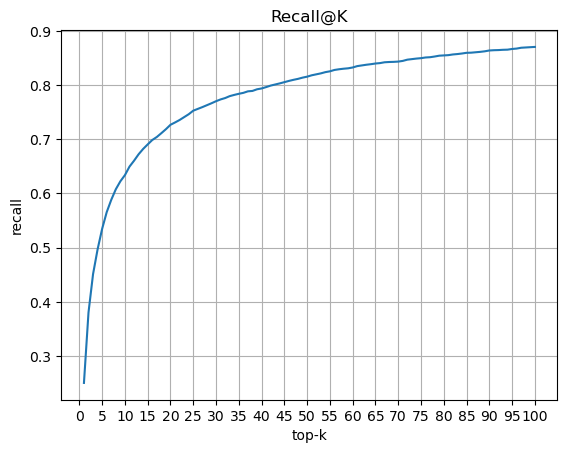

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, 101), recalls)
ax.set_xlabel('top-k')
ax.set_ylabel('recall')
ax.set_xticks(range(0, 101, 5))
ax.set_title('Recall@K')
ax.grid()

In [15]:
print("recall @ 1 :", recalls[0])
target_recall = (int(recalls[0] * 100)//10 + 1) * 10
for i in range(1, 100):
    if recalls[i] >= target_recall/100:
        print("recall @", i+1, ":", recalls[i])
        target_recall += 10
print("recall @ 100 :", recalls[99])

recall @ 1 : 0.25025303643724695
recall @ 2 : 0.38031376518218624
recall @ 3 : 0.45116396761133604
recall @ 5 : 0.534919028340081
recall @ 8 : 0.6077935222672065
recall @ 17 : 0.7042004048582996
recall @ 43 : 0.8011133603238867
recall @ 100 : 0.8704453441295547


왜 100개의 문서나 찾아도 확인할 수 없는 문서가 약 13%나 존재하는 걸까?  

In [26]:
import random

In [16]:
def get_bad_idx(rankings, k):
    rtn = []
    for i, rank in enumerate(rankings):
        if rank > k:
            rtn.append(i)
    return rtn

In [17]:
bad_idx = get_bad_idx(rankings, 100)

In [19]:
len(bad_idx)

512

In [27]:
bad_idx = random.sample(bad_idx, 5)
for i in bad_idx:
    print("Q: ", questions[i])
    print("C: ", answers[i])
    print("A: ", train_dataset['answers'][i]['text'][0], "from", train_dataset['title'][i])   
    print()
# 특정 맥락에서만 정답을 확인할 수 있는 질문(ex. 어떤 영화에서 어떤 배우가 어떤 역할을 했는지)이 꽤 있는 것으로 보인다.
# 이런 경우는 retrieval이 잘 안될 것 같다. (특정 창작물에 관련된 문서를 retrieval해야 하는 경우)
# Dense retrieval를 하려면 따로 데이터셋을 구하는 게 맘 편해 보인다.

Q:  철수가 피하려고 하지만 사실 친구로 생각하는 사람은?
C:  카스카베 방위대의 일원. 부잣집 외아들로 태어났지만 아빠는 일 때문에 해외출장이 일상이라 집에 들어오는 일이 거의 없어서 엄마랑 둘이서 지낸다고 봐도 무방하다. 어릴때부터 각종 영재교육을 받아온 탓에 또래들보다 똘똘하고 현명한데다 상식이 풍부하고 어른스럽게 행동하는 편. 일단 친구들 앞에서는 액션가면 같은 만화들을 '애들이나 보는 유치한 만화'라고 치부하지만 실은 자신도 그 만화들을 매우 좋아한다. 특히 마법소녀 모에P 여주인공을 매우 좋아해 사진과 피규어들을 잔뜩 모아놓고 CD까지 사놔 몰래 음악을 틀어놓고 즐긴다. 그래서 친구들한테 모에P 덕후라는걸 들키지 않기위해 노력하는 에피소드가 몇개 있다.\n\n이를 두고 팬들 사이에서는 남자애라고 저런걸 숨기는게 오히려 성 고정관념을 부추기는것이며 그냥 속 시원스럽게 밝혔으면 좋겠다는 의견이 있다.\n\n일단 친구들과의 관계는 원만한 편이지만 유독 노하라 신노스케하고는 가급적 단둘이 있는걸 피하려 든다. 툭하면 자기 귀를 핥거나 바람 불어넣기 등의 행동을 하는데다 그와 같이 있으면 필시 귀찮은 사건사고들이 연달아 벌어지기 때문. 더군다나 신노스케가 마음대로 그를 '그렇고 그런 사이'라고 떠드는 학원 친구들이나 좋아하고 있는 여자애 앞에서 망신당한 적도 많았다. 하지만 아주 가끔은 신노스케 덕을 볼때도 있었다.\n\n한번은 엄마 미네코가 지나치게 부담감을 키우자 스트레스가 폭발해 공원에서 우연히 만난 신노스케 집에서 하룻밤만 재워달라고 한다. 나중에 모든 사정을 알게된 미네코는 학원뺑뺑이 돌린걸 사과하며 하루만 재워달라고 미사에한테 부탁했고 그날밤, 이부자리를 펼쳐놓고 신노스케와 즐겁게 베개싸움을 하고 놀았다. 이후에는 성적이 떨어졌다는 이유 하나로 같이 다니던 학원 친구들한테서 따돌림을 당했다. 충격을 받아 비를 맞고 터덜터덜 걸어가고 있는데 누군가 우산을 씌워줬다. 바로 장을 보고 돌아오던 신노스케와 미사에였다.\n\n이후 그는 신노스케 집에서 